# <span style="color:green"> VANILLA RNN

# Importing Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import tensorflow as tf
from sklearn.datasets import load_digits 
from sklearn.cross_validation import train_test_split
import pylab as pl
from IPython import display
import sys
%matplotlib inline

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Vhanilla RNN class and functions

$$
\begin{align}
Hidden\;state: h^t&=g(x^tU+h^{t-1}W+b) \\
output\;layer: o^t&=h^tV+c \\
\hat{y}^t&=\text{softmax}(o^t)
\end{align}
$$

In [2]:
class RNN_cell(object):


    def __init__(self, input_size, hidden_layer_size, target_size):

        # Initialization of given values
        self.input_size = input_size
        self.hidden_layer_size = hidden_layer_size
        self.target_size = target_size

        # Weights and Bias for input and hidden tensor
        self.U = tf.Variable(tf.truncated_normal(
            [self.input_size, self.hidden_layer_size],stddev=.01))
        self.W = tf.Variable(tf.truncated_normal(
            [self.hidden_layer_size, self.hidden_layer_size],stddev=.01))
        self.b = tf.Variable(tf.zeros([self.hidden_layer_size]))

        # Weights for output layers
        self.V = tf.Variable(tf.truncated_normal(
            [self.hidden_layer_size, self.target_size],mean=0,stddev=.01))
        self.c = tf.Variable(tf.truncated_normal([self.target_size],mean=0,stddev=.01))

        # Placeholder for input vector with shape[batch, seq, embeddings]
        self._inputs = tf.placeholder(tf.float32,
                                      shape=[None, None, self.input_size],
                                      name='inputs')

        # Processing inputs to work with scan function
        self.processed_input = process_batch_input_for_RNN(self._inputs)


        self.initial_hidden = self._inputs[:, 0, :]
        self.initial_hidden = tf.matmul(
            self.initial_hidden, tf.zeros([input_size, hidden_layer_size]))

    # Function for vhanilla RNN.
    def vanilla_rnn(self, previous_hidden_state, x):

        current_hidden_state = tf.tanh(
            tf.matmul(previous_hidden_state, self.W) +
            tf.matmul(x, self.U) + self.b)

        return current_hidden_state

    # Function for getting all hidden state.
    def get_states(self):

        # Getting all hidden state throuh time
        all_hidden_states = tf.scan(self.vanilla_rnn,
                                    self.processed_input,
                                    initializer=self.initial_hidden,
                                    name='states')

        return all_hidden_states

    # Function to get output from a hidden layer
    def get_output(self, hidden_state):

        output = tf.matmul(hidden_state, self.V) + self.c

        return output

    # Function for getting all output layers
    def get_outputs(self):

        all_hidden_states = self.get_states()

        all_outputs = tf.map_fn(self.get_output, all_hidden_states)

        return all_outputs


# Function to convert batch input data to use tf.scan ops of tensorflow.
def process_batch_input_for_RNN(batch_input):

    batch_input_ = tf.transpose(batch_input, perm=[1, 0, 2])
    X = tf.transpose(batch_input_)

    return X


# Placeholder and initializers


In [3]:
hidden_layer_size = 50
input_size = 8
target_size = 10

In [4]:
y = tf.placeholder(tf.float32, shape=[None, target_size],name='inputs')

# Models

In [5]:
#Initializing rnn object
rnn=RNN_cell( input_size, hidden_layer_size, target_size)

In [6]:
#Getting all outputs from rnn
outputs = rnn.get_outputs()

In [7]:
#Getting final output through indexing after reversing
last_output = outputs[-1]

In [8]:
#Computing the Cross Entropy loss
loss = tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits_v2(logits=last_output, labels=y))

In [9]:
# Trainning with Adadelta Optimizer
train_step = tf.train.AdamOptimizer().minimize(loss)

In [10]:
#Calculatio of correct prediction and accuracy
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(last_output,1))
accuracy = (tf.reduce_mean(tf.cast(correct_prediction, tf.float32)))*100

# Dataset Preparation

In [11]:
#Function to get on hot
def get_on_hot(number):
    on_hot=[0]*10
    on_hot[number]=1
    return on_hot

In [12]:
#Using Sklearn MNIST dataset.
digits = load_digits()
X=digits.images
Y_=digits.target

# One hot encoding
Y=list(map(get_on_hot,Y_))

In [13]:
#Getting Train and test Dataset
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.22, random_state=42)

#Cuttting for simple iteration
X_train=X_train[:1400]
y_train=y_train[:1400]

In [14]:
sess=tf.Session()
sess.run(tf.global_variables_initializer())

In [15]:
#Iterations to do trainning
train_loss = []
test_loss = []
train_acc = []
test_acc = []

for epoch in range(120):
    
    start=0
    end=100
    
    train_loss_collector = []
    test_loss_collector = []
    train_acc_collector = []
    test_acc_collector = []
    
    for i in range(14):
        
        X=X_train[start:end]
        Y=y_train[start:end]
        start=end
        end=start+100 # 每次訓練100張圖片
        _, train_loss_batch, train_acc_batch = sess.run([train_step, loss, accuracy],feed_dict={rnn._inputs:X, y:Y})
        
        train_loss_collector.append(train_loss_batch)
        train_acc_collector.append(train_acc_batch)
    
    train_loss_collector = np.mean(train_loss_collector) # 平均一個batch的loss
    train_acc_collector = np.mean(train_acc_collector) # 平均一個batch的acc
    
    train_loss.append(train_loss_collector)
    train_acc.append(train_acc_collector)
    
    test_loss_=sess.run(loss,feed_dict={rnn._inputs:X_test, y:y_test})
    test_acc_=sess.run(accuracy,feed_dict={rnn._inputs:X_test, y:y_test})
    
    test_loss.append(test_loss_)
    test_acc.append(test_acc_)
    
    print('Epoch=%d/120, train_loss=%.2f, train_acc=%.2f / test_loss=%.2f, test_acc=%.2f' % 
          (epoch+1, train_loss_collector, train_acc_collector, test_loss_, test_acc_))

Epoch=1/120, train_loss=229.35, train_acc=18.71 / test_loss=898.00, test_acc=27.27
Epoch=2/120, train_loss=219.29, train_acc=29.00 / test_loss=819.15, test_acc=28.03
Epoch=3/120, train_loss=196.46, train_acc=28.64 / test_loss=741.16, test_acc=25.00
Epoch=4/120, train_loss=180.72, train_acc=30.64 / test_loss=689.51, test_acc=31.57
Epoch=5/120, train_loss=165.69, train_acc=40.07 / test_loss=624.87, test_acc=43.43
Epoch=6/120, train_loss=149.31, train_acc=49.86 / test_loss=565.20, test_acc=52.78
Epoch=7/120, train_loss=135.50, train_acc=55.29 / test_loss=516.60, test_acc=57.07
Epoch=8/120, train_loss=123.87, train_acc=59.36 / test_loss=472.28, test_acc=63.13
Epoch=9/120, train_loss=113.17, train_acc=64.79 / test_loss=430.08, test_acc=66.67
Epoch=10/120, train_loss=103.26, train_acc=68.86 / test_loss=391.25, test_acc=70.96
Epoch=11/120, train_loss=94.34, train_acc=71.86 / test_loss=356.85, test_acc=73.48
Epoch=12/120, train_loss=86.46, train_acc=74.50 / test_loss=325.89, test_acc=76.01
Epo

Epoch=102/120, train_loss=0.90, train_acc=100.00 / test_loss=50.61, test_acc=97.98
Epoch=103/120, train_loss=0.87, train_acc=100.00 / test_loss=50.68, test_acc=97.98
Epoch=104/120, train_loss=0.84, train_acc=100.00 / test_loss=50.76, test_acc=97.98
Epoch=105/120, train_loss=0.82, train_acc=100.00 / test_loss=50.85, test_acc=97.98
Epoch=106/120, train_loss=0.79, train_acc=100.00 / test_loss=50.94, test_acc=97.98
Epoch=107/120, train_loss=0.77, train_acc=100.00 / test_loss=51.03, test_acc=97.98
Epoch=108/120, train_loss=0.74, train_acc=100.00 / test_loss=51.12, test_acc=97.98
Epoch=109/120, train_loss=0.72, train_acc=100.00 / test_loss=51.21, test_acc=97.98
Epoch=110/120, train_loss=0.70, train_acc=100.00 / test_loss=51.31, test_acc=97.98
Epoch=111/120, train_loss=0.68, train_acc=100.00 / test_loss=51.40, test_acc=97.98
Epoch=112/120, train_loss=0.66, train_acc=100.00 / test_loss=51.49, test_acc=97.98
Epoch=113/120, train_loss=0.65, train_acc=100.00 / test_loss=51.59, test_acc=97.98
Epoc

In [16]:
from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt
rcParams['figure.figsize'] = (12,8)

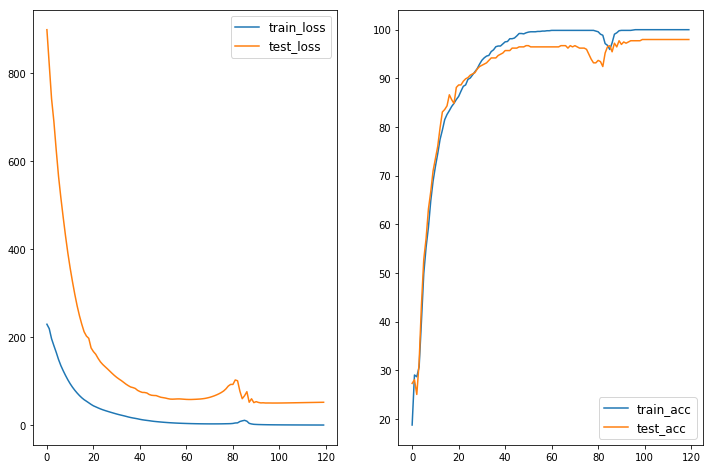

In [17]:
fig, axes = plt.subplots(1,2)

axes[0].plot(np.arange(120), train_loss, label='train_loss')
axes[0].plot(np.arange(120), test_loss, label='test_loss')
axes[0].legend(loc='upper right',prop={'size':12})

axes[1].plot(np.arange(120), train_acc, label='train_acc')
axes[1].plot(np.arange(120), test_acc, label='test_acc')
axes[1].legend(loc='lower right',prop={'size':12})

plt.show()

In [18]:
print('Min train loss:%.2f' % np.min(train_loss))
print('Max train accuracy:%.2f' % np.max(train_acc))
print('------------------------')
print('Min test loss:%.2f' % np.min(test_loss))
print('Max test accuracy:%.2f' % np.max(test_acc))

Min train loss:0.55
Max train accuracy:100.00
------------------------
Min test loss:50.49
Max test accuracy:97.98
